# TP1 - Bandits manchots

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm

## Action-Value Function

La fonction de valeur d'action est représenté par q(a) et définit la récompense moyenne pour chaque action à un instant t.

$$Q(a) = E[r|a]$$


## No Exploration (Greedy Approach)
Pour estimer la valeur associée à une action (ici une mahcine), on peut faire la moyenne des récompenses pour chaque action au fur et à mesure :

$$Q_t(a) = \frac{\sum^t_{i=1} 1_{(a_t=a)}.R_i}{\sum^t_{i=1} 1_{(a_t=a)}}$$

Une stratégie "gloutone" serait à chaque fois de prendre la machine avec la meilleur valeur:

$$a^* = \underset{a \in A}{argmax} Q_t(a)$$

Evaluer $Q_t(a)$ à chaque itération $t$ nécessiterait de stocker l'historique des récompenses en mémoire. Pour éviter cela, on peut faire une "somme glissante". Ainsi, à chaque itération $t$, la valeur d'action associée à chaque action peut être calculé de la manière suivante :

$$Q_t(a) = \frac{Q_{t-1}(a)N_t(a_t)+R_t. 1_{(a_t=a)}}{N_t(a_t)}$$

$$Q_t(a) = Q_{t-1}(a) + \frac{1}{N_t(a_t)}(R_t - Q_{t-1}(a))$$



Nous allons faire de sessions à 2000 jetons pour 10 machines. A chaque jeton, nous lançons l'expérience 2000 fois et nous faisons la moyenne des récompenses (lissage).

Chaque machine est représenté par une moyenne $m_a$ générée d'après une loi normale centrée réduite $N(0,1)$.
La récompense d'une machine $a$ sera un échantillon d'une loi normale d'espérance $m_a$ et de variance unitaire $N(m_a,1)$.

In [ ]:
nb_machines = 10 
print(f"Nombre de machines : {nb_machines}")

nb_of_run = 2000
print(f"Nombre de jetons : {nb_of_run}")

nb_of_experiment = 2000
print(f"Nombre d'experiences : {nb_of_experiment}")

def generer_machines(nb_machines):
    machines=np.random.normal(0,1,nb_machines)
    return machines


machines = generer_machines(nb_machines)

print(f"Esperance des {nb_machines} machines :")
print(machines)

Nombre de machines : 10
Nombre de jetons : 2000
Nombre d'experiences : 2000
Esperance des 10 machines :
[-0.78983189  0.73066632 -0.35414774  0.11664106 -0.31741255  1.01772178
  0.76856006 -0.2323688   1.70654577 -0.01166808]


Dans ce notebook, les méthodes implémentées sont :
- ϵ-greedy
- ϵ-greedy (avec initialisation optimiste)
- ϵ-greedy (avec intervalle de confiance - UCB)
- méthode de gradient

Pour chaque stratégie, nous mesurons à chaque itération :
- la récompense cumulée au $t^{ème}$ jeton: $R_t$
- la précision au $t^{ème}$ jeton: $\frac{N_t^*}{t}$ où $N_t^*$ est le nombre de fois où on a choisi la meilleure machine et $N_t^*$ est le nombre de jetons utilisés

In [ ]:
def epsilon_greedy_method(machines,nb_of_run,epsilon, initialisation="realistic", optimistic_level=0): 
  precisions = np.zeros(nb_of_run)  
  recompenses_moyennes = np.zeros(nb_of_run)
  nb_machines = len(machines)

  sommes_recompenses = {k:0 for k in range(nb_machines)}
  Qt =  np.zeros(nb_machines)  

  if initialisation == "optimistic":
     Qt += optimistic_level
     sommes_recompenses = {k:optimistic_level for k in range(nb_machines)}

     

  total_des_recompenses = 0
  cumul = 0
  
  meilleure_machine = np.argmax(machines)
  compteur_choix_actions = np.zeros(nb_machines)  

  for k in range(1,nb_of_run):
    exploration = np.random.binomial(1, epsilon)

    if exploration:
      # Si p < epsilon : on explore
      action = np.random.choice(list(range(nb_machines)))
    else:
      # Si p > epsilon : on exploite
      maxs = np.argwhere(Qt == np.max(Qt)).ravel()
      if len(maxs) > 1:
        action = np.random.choice(maxs)
      else:
        action = np.argmax(Qt) 
      
    # Si on choisit la machine optimale

    cumul += (action == meilleure_machine)
    precisions[k] = cumul/k

    # Récompense de machine choisie
    recompense_immediate = np.random.normal(machines[action], 1,1) 

    sommes_recompenses[action] = sommes_recompenses[action] + recompense_immediate
    compteur_choix_actions[action] = compteur_choix_actions[action] + 1

    Qt[action] = sommes_recompenses[action] / (compteur_choix_actions[action])
    
    total_des_recompenses += recompense_immediate
    recompenses_moyennes[k] = total_des_recompenses/k
     
  return recompenses_moyennes,precisions


def IC_method(machines, nb_of_run , epsilon=0,c=1,optimistic_level=0):
  precisions = np.zeros(nb_of_run)  
  recompenses = np.zeros(nb_of_run)
  sommes_recompenses = {k:0 for k in range(nb_machines)}
  intervalle_confiance_ak = np.ones(nb_machines) * 5 
  Qt =  np.zeros(nb_machines)  

  total_des_recompenses=0
  cumul = 0

  meilleure_machine = np.argmax(machines)
  compteur_choix_actions = np.zeros(nb_machines)  

  for k in range(1,nb_of_run):
    exploration = np.random.binomial(1, epsilon)

    if exploration:
      # Si p < epsilon : on explore
      action = np.random.choice(list(range(nb_machines)))
    else:
      # Si p > epsilon : on exploite
      maxs = np.argwhere(intervalle_confiance_ak == np.max(intervalle_confiance_ak)).ravel()
      if len(maxs) > 1:
        action = np.random.choice(maxs)
      else:
        action = np.argmax(intervalle_confiance_ak)  
      
    # Si on choisit la machine optimale
    cumul += action == meilleure_machine
    precisions[k] = cumul/k #calcule la précision

    # Récompense de machine choisie
    recompense_immediate = np.random.normal(machines[action],1,1)

    sommes_recompenses[action] = sommes_recompenses[action] + recompense_immediate   
    compteur_choix_actions[action] = compteur_choix_actions[action] + 1

    Qt[action] = sommes_recompenses[action] / (compteur_choix_actions[action])

    # intervalle_confiance_ak = R_ak + c*np.sqrt(np.log(k)./compteur_choix_actions)  
    for j in range(nb_machines):
      if compteur_choix_actions[j] != 0:
        intervalle_confiance_ak[j] = Qt[j] + c*np.sqrt(np.log(k)/compteur_choix_actions[j])  
        
    total_des_recompenses += recompense_immediate
    recompenses[k] = total_des_recompenses / k

    
  return recompenses, precisions


def compute_preferences(preferences, a, R, q, alpha, pi):  
  for i in range(len(preferences)):
    if (i==a):
      preferences[i]+= alpha*(q-R)*(1-pi[a])
    else:
      preferences[i]-= alpha*(q-R)*(pi[a])
  return preferences
    

def gradient_bandits(machines, run , alpha):
  """
  Cette fonction applique la méthode du gradient stochastique 
  """
  precisions=np.zeros(run)
  meilleure_machine=np.argmax(machines)
  R_ak = np.zeros(nb_machines)  
  recompenses=np.zeros(run)
  compteur_choix_actions= np.zeros(nb_machines)
  total_des_recompenses=0

  sommes_recompenses = {k:0 for k in range(10)}


  #Initialisation de la matrice de préférences
  preferences=np.zeros(nb_machines)
  politique = np.exp(preferences)/(np.sum(np.exp(preferences)))
  cumul=0

  for k in range(1,run):
    action = np.random.choice(np.arange(nb_machines), p = politique)
    cumul += action == meilleure_machine
    precisions[k] = cumul/k
    recompense_immediate = np.random.normal(machines[action],1,1)
    total_des_recompenses+=recompense_immediate
    recompenses[k]=total_des_recompenses/k

    sommes_recompenses[action] = sommes_recompenses[action] + recompense_immediate    
    R_ak[action] = sommes_recompenses[action] / (compteur_choix_actions[action] + 1)

    # R_ak[action]= (R_ak[action]*(compteur_choix_actions[action]+1)+recompense_immediate)/(compteur_choix_actions[action]+2)
    compteur_choix_actions[action] = compteur_choix_actions[action] + 1
    preferences = compute_preferences(preferences.copy(), action, recompenses[k], recompense_immediate, alpha, politique)

    politique = np.exp(preferences)/(np.sum(np.exp(preferences)))


  return recompenses, precisions



def lancement_algo(machines, nb_of_run, algo, **kwargs):
  """
  Cette fonction renvoie les récompenses et la précision de l'agent pour un algorithme donné
  """
  if algo == "epsilon_greedy":
    epsilon = kwargs.pop('epsilon')
    recompenses,precisions = epsilon_greedy_method(machines, nb_of_run, epsilon)

  if algo == "epsilon_greedy_optimistic":
    epsilon = kwargs.pop('epsilon')
    optimistic_level = kwargs.pop('optimistic_level')
    recompenses,precisions = epsilon_greedy_method(machines, nb_of_run, epsilon=epsilon, initialisation="optimistic",optimistic_level=optimistic_level)
  
  if algo == "IC":
    epsilon = kwargs.pop('epsilon')
    c = kwargs.pop('c')
    recompenses,precisions = IC_method(machines, nb_of_run, epsilon=epsilon, c = c)

  if algo == "grad":
    alpha = kwargs.pop('alpha')
    recompenses,precisions = gradient_bandits(machines, nb_of_run, alpha)  

  return recompenses, precisions

def compute_mean_reward_and_accuracy(machines, nb_of_run , nb_of_experiment, algo="epsilon_greedy", **kwargs):
  """
  Cette fonction calcule la moyenne des récompenses et des précisions
  """

  recompenses = np.zeros((nb_of_experiment,nb_of_run))
  precisions = np.zeros((nb_of_experiment,nb_of_run))
  
  for i in tqdm(range(nb_of_experiment)):
    recompenses[i,:],  precisions[i,:] = lancement_algo(machines, nb_of_run , algo, **kwargs)
  
  
  moyenne_recompenses =  np.mean(recompenses, axis=0)  
  moyenne_precisions =  np.mean(precisions, axis=0)

  return moyenne_recompenses, moyenne_precisions

# Epsilon Greedy

La stratégie $ϵ$-greedy consiste à
- adopter la stratégie gloutone $1-\epsilon$ % du temps (exploitation): $$a^* = \underset{a \in A}{argmax} Q_t(a)$$.
- $ϵ$ % du temps, l'action est choisi selon une loi uniforme sur l'ensemble des actions de l'espace des actions.

In [ ]:
eps_0_reward_average, eps_0_accu_average = compute_mean_reward_and_accuracy(machines, nb_of_run , nb_of_experiment, algo="epsilon_greedy",epsilon = 0)
eps_01_reward_average, eps_01_accu_average = compute_mean_reward_and_accuracy(machines, nb_of_run , nb_of_experiment, algo="epsilon_greedy", epsilon =0.1)
eps_001_reward_average, eps_001_accu_average = compute_mean_reward_and_accuracy(machines, nb_of_run , nb_of_experiment, algo="epsilon_greedy", epsilon=0.05)

100%|██████████| 2000/2000 [05:42<00:00,  5.84it/s]


Text(0.5, 1.0, 'Précisions (epsilon greedy)')

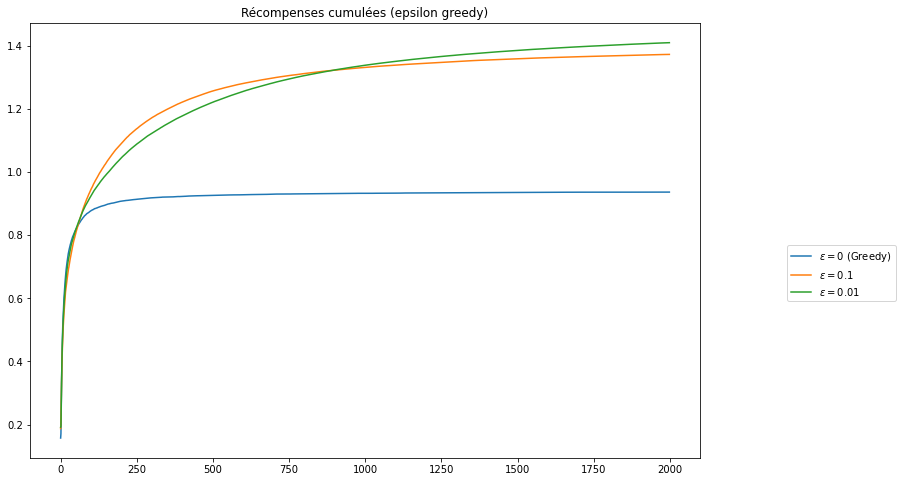

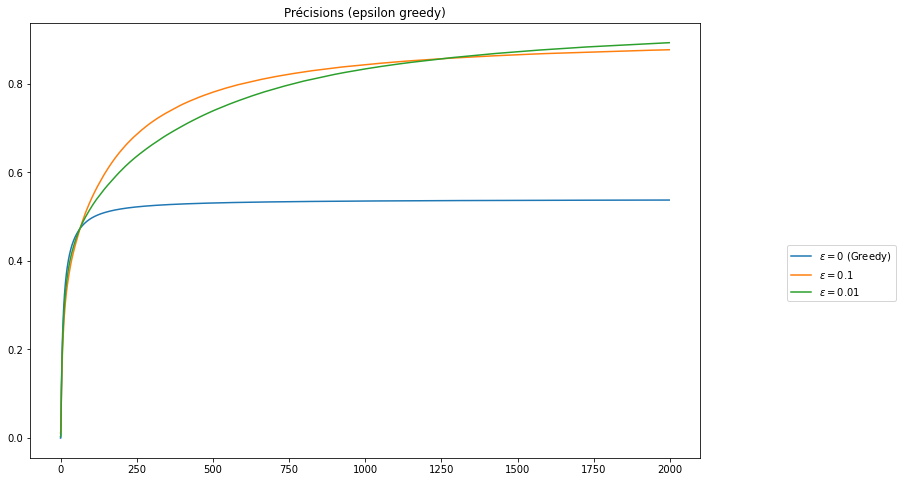

In [ ]:
# Affichage
plt.figure(figsize=(12,8))
plt.plot(eps_0_reward_average[1:], label="$\epsilon=0$ (Greedy)")
plt.plot(eps_01_reward_average[1:], label="$\epsilon=0.1$")
plt.plot(eps_001_reward_average[1:], label="$\epsilon=0.01$")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.title('Récompenses cumulées (epsilon greedy)')

plt.figure(figsize=(12,8))
plt.plot(eps_0_accu_average[1:], label="$\epsilon=0$ (Greedy)")
plt.plot(eps_01_accu_average[1:], label="$\epsilon=0.1$")
plt.plot(eps_001_accu_average[1:], label="$\epsilon=0.01$")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.title('Précisions (epsilon greedy)')


Le premier graphique représente la récompense moyenne cumulée pour chaque méthode à chaque itération (jeton).
Le deuxième graphique représente le précision moyenne cumulée obtenue à chaque itération (jeton).

- On remarque que la méthode purement "gloutone" (ϵ=0) continue d'exploiter un bras non optimal. Elle obtient ainsi la plus faible récompense cumulée et la plus faible précision moyenne.

- La méthode ϵ-greedy ϵ = 0.1 explore 10% du temps, et arrive à trouver assez vite un meilleur bras que la méthode gloutone. L'exploration permet d'avoir une estimation des valeurs pour les autres machines. Cependant, elle ne sélectionne pas la meilleure machine plus de 91% à cause des phases d'exploration.

- La méthode ϵ-greedy ϵ = 0.05 explore 5% du temps, et met plus de temps à avoir une estimation fidèle des valeurs pour chaque machine. Elle met ainsi plus de temps à trouver la machine optimale que la méthode ϵ = 0.1. Néanmoins, une fois que les estimations des valeurs de chaque machine sont suffisamment fidèles, la méthode ϵ = 0.05 dépasse la méthode ϵ = 0.1 en termes de précision et de récompenses cumulées, car on choisira la bonne machine au plus 96% comparé à 91% pour ϵ = 0.1.

Remarque : ici, nous avons choisi des récompenses avec une variance unitaire. Si on avait un bruit avec plus de variance pour les récomposenses, plus d'exploration est nécessaire pour trouver la machine optimale. L'exploration est également requise dans le cas où les moyenne des récompenses ne sont pas stationnaires.



# Epsilon Greedy Optimistic

Avec la méthode purement gloutone (ϵ = 0), il est possible d'inciter l'algorithme à explorer en initialisant les valeurs initiales des machine de façon "optimiste". C'est-à-dire que les valeurs ne sont plus initialisées à 0, mais avec un certain niveau "d'optimisme". En forçant l'exploration, l'algorithme va pouvoir essayer de nouvelles actions un certain nombre de fois pour estimer leurs valeurs. Cela permet d'améliorer la convergence.
Plus on augmente la valeur de c, plus on force l'agent a exploré de façon alétoire la machine optimale au début.

In [ ]:
# Initialisation optimiste
eps_0_opt_reward_average, eps_0_opt_accu_average = compute_mean_reward_and_accuracy(machines, nb_of_run , nb_of_experiment, algo="epsilon_greedy_optimistic", 
                                                                                    epsilon =0, optimistic_level=5)
eps_01_reward_average, eps_01_accu_average = compute_mean_reward_and_accuracy(machines, nb_of_run , nb_of_experiment, algo="epsilon_greedy", epsilon =0.1)



100%|██████████| 2000/2000 [05:48<00:00,  5.73it/s]


In [ ]:
eps_0_opt1_reward_average, eps_0_opt1_accu_average = compute_mean_reward_and_accuracy(machines, nb_of_run , nb_of_experiment, algo="epsilon_greedy_optimistic", 
                                                                                    epsilon =0, optimistic_level=1)

100%|██████████| 2000/2000 [05:44<00:00,  5.80it/s]


Text(0.5, 1.0, 'Précisions  (epsilon greedy avec et sans initilisation optimale)')

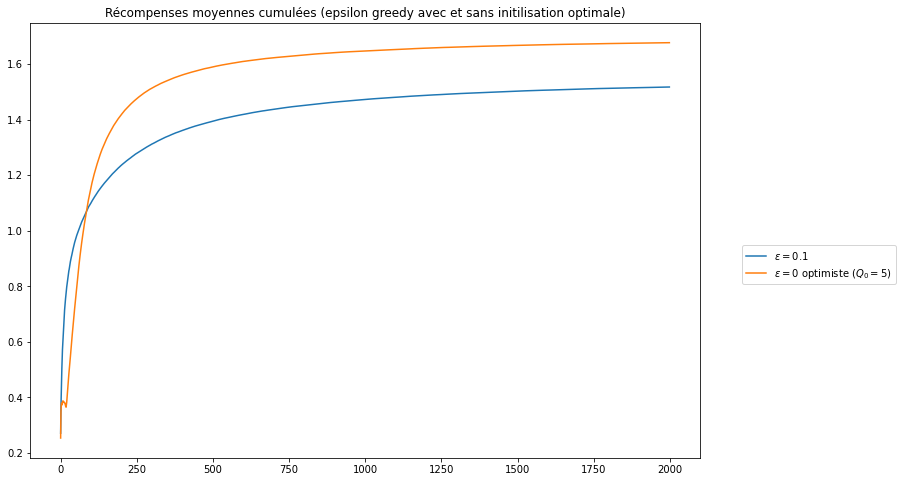

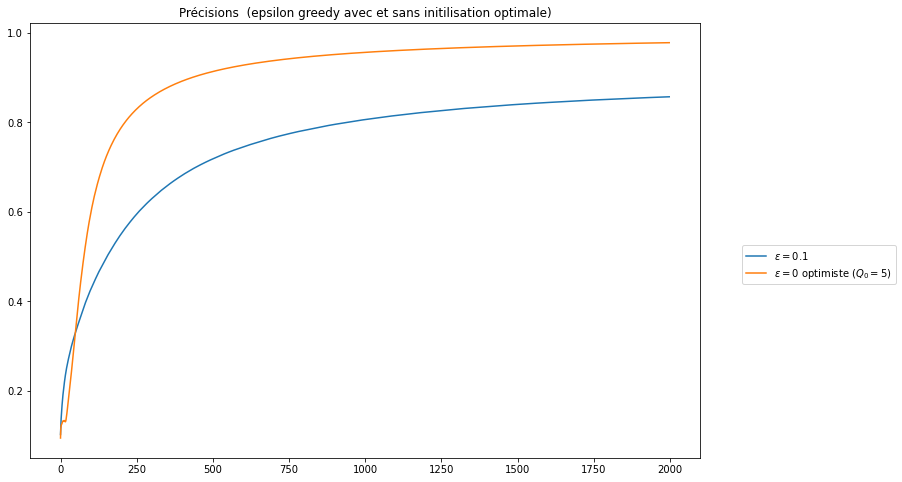

In [ ]:
plt.figure(figsize=(12,8))
# plt.plot(eps_0_reward_average[1:], label="$\epsilon=0$")
plt.plot(eps_01_reward_average[1:], label="$\epsilon=0.1$")
plt.plot(eps_0_opt_reward_average[1:], label="$\epsilon=0$ optimiste $(Q_0 = 5)$")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.title('Récompenses moyennes cumulées (epsilon greedy avec et sans initilisation optimale)')


plt.figure(figsize=(12,8))
# plt.plot(eps_0_accu_average[1:], label="$\epsilon=0$")
plt.plot(eps_01_accu_average[1:], label="$\epsilon=0.1$")
plt.plot(eps_0_opt_accu_average[1:], label="$\epsilon=0$ optimiste $(Q_0 = 5)$")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.title('Précisions  (epsilon greedy avec et sans initilisation optimale)')


- On remarque qu'avec l'initialisation "optimiste" ($Q_0 = 5$), on arrive à avoir plus rapidement une estimation de valeur pour chaque machine au début tout en conservant la propriété ϵ = 0. C'est-à-dire qu'on exploite la meilleure machine (sans explorer) sur la base des estimations obtenus grâce à l'exploration au début. Ici, un niveau "d'optimisme" de 5 est suffisant pour trouver la machine optimale.


- Q_0 = 1

- Cette méthode d'initialisation optimiste suppose que les valeurs des machines sont stationnaires. Si la récompense moyenne d'une machine n'était pas stationnaire $m_a(t)$ , alors il faudrait utiliser ϵ > 0 pour forcer l'exploration de façon continue.

# Intervalle de confiance (UCB)

Nous allons maintenant appliquer la méthode UCB qui consiste à mesurer l'incertitude sur la valeur de chaque machine. La borne supérieure de l'intervalle de confiance des valeurs des machines est calculée comme suit :
$$ A_t = \underset{a}{\text{argmax } } [ Q_t(a) + c\sqrt{\frac{ln(t)}{N_t(a)}}] $$
où Q_t(a) est l'estimation de la valeur de la machine $a$ pour le $t_{ème}$ jeton; c est le niveau de confiance.
Ainsi, plus on choisit une machine et plus son incertitude baisse. Cela incite l'agent à explorer les machines les moins utilisées qui ont une incertitude importante sur leurs valeurs.
Nous choisissons un niveau de confiance $C=2$. Chaque borne supérieure est initialisée à 5.

Le terme $\sqrt{\frac{ln(t)}{N_t(a)}}$ est une mesure de l'incertitude associée à l'estimation de la valeur de $Q_t(a)$. La quantité à maximiser $Q_t(a) + c\sqrt{\frac{ln(t)}{N_t(a)}}$ est ainsi analogue à une borne supérieure de la valeur réelle associé à l'action $a$.

In [ ]:
eps_0_UCB2_reward_average, eps_0_UCB2_accu_average = compute_mean_reward_and_accuracy(machines, nb_of_run , nb_of_experiment, algo = "IC", epsilon = 0, c=2)

100%|██████████| 2000/2000 [11:18<00:00,  2.95it/s]


In [ ]:
eps_0_UCB5_reward_average, eps_0_UCB5_accu_average = compute_mean_reward_and_accuracy(machines, nb_of_run , nb_of_experiment, algo = "IC", epsilon = 0, c=5)


100%|██████████| 2000/2000 [11:17<00:00,  2.95it/s]


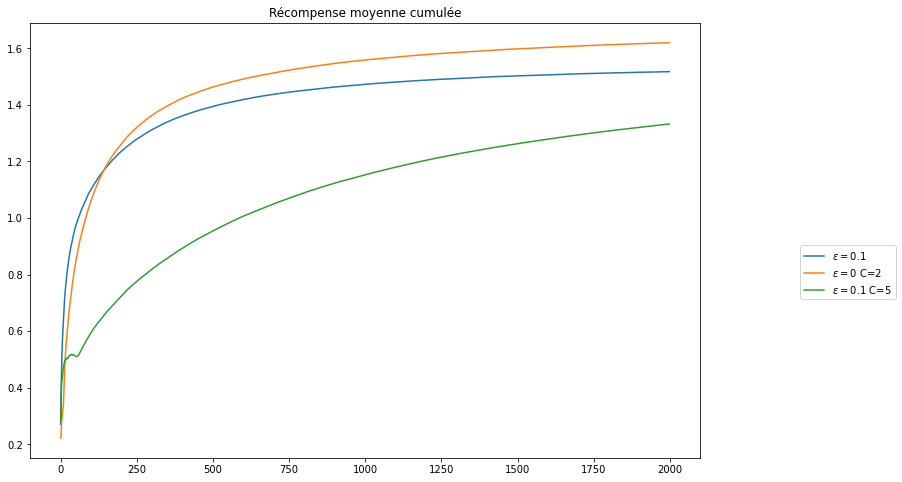

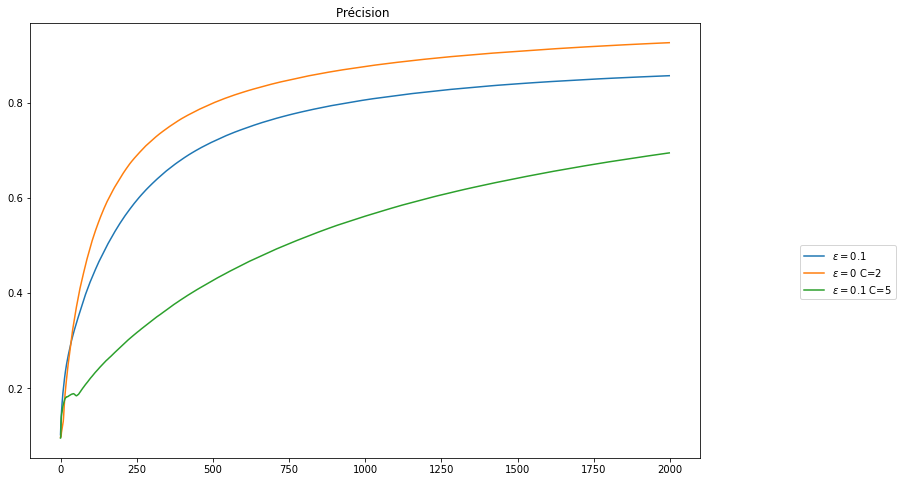

In [ ]:
plt.figure(figsize=(12,8))
plt.title("Récompense moyenne cumulée")
plt.plot(eps_01_reward_average[1:], label="$\epsilon=0.1$")
plt.plot(eps_0_UCB2_reward_average[1:], label="$\epsilon=0$ C=2")
# plt.plot(eps_0_UCB1_reward_average[1:], label="$\epsilon=0.1$ C=1")
plt.plot(eps_0_UCB5_reward_average[1:], label="$\epsilon=0.1$ C=5")
plt.legend(bbox_to_anchor=(1.3, 0.5))

plt.figure(figsize=(12,8))
plt.title("Précision ")
plt.plot(eps_01_accu_average[1:], label="$\epsilon=0.1$")
plt.plot(eps_0_UCB2_accu_average[1:], label="$\epsilon=0$ C=2")
# plt.plot(eps_0_UCB1_accu_average[1:], label="$\epsilon=0.1$ C=1")
plt.plot(eps_0_UCB5_accu_average[1:], label="$\epsilon=0.1$ C=5")
plt.legend(bbox_to_anchor=(1.3, 0.5))

- On remarque que la méthode UCB avec $C=2$ permet d'obtenir d'atteindre plus rapidement une meilleure précision ainsi qu'une meilleure récompensense moyenne cumulée que la méthode ϵ-greedy (ϵ=0.1). Les bornes d'incertitudes supérieures ont permis d'inciter l'agent à explorer les machines peu utilisées pour obtenir une estimation plus fidèles de leurs valeurs. Une fois les niveaux d'incertitudes suffisamment faibles, les machines avec les estimations de valeurs les plus élevées sont exploitées.

- On remarque également qu'augmenter le niveau de confiance $C$ entraîne une diminution de la récompense moyenne et de la précision (exemple: les courbes des méthodes UCB C=2 et C=5 ci-dessus). En effet, plus on augmente la valeur de $C$ et plus la stratégie de l'agent ressemble à une recherche aléatoire.

# Montée de gradient / soft-max (Boltzmann) distribution

Jusqu'à maintenant, nous utilisions l'estimation des valeurs directement pour choisir une action (machine avec la meilleur estimation).
Maintenant, nous allons ajouter construire une fonction de préférence $H_t(a)$ et nous choisirons plus souvent les actions avec une préférence élevée.

Pour obtenir une probabilité de choisir une action, nous allons utiliser la fonction softmax (ou distribution de Boltzmann) :
$$P(A_t=a) = \frac{e^{H_t(a)}}{\underset{b \in A}{\sum} e^{H_t(b)}}$$ 

In [ ]:
# Méthode du gradient stochastique
# eps_01_grad3_reward_average,eps_01_grad3_accu_average = compute_mean_reward_and_accuracy(machines, nb_of_run , nb_of_experiment, algo = "grad", alpha=0.01)
eps_001_grad1_reward_average,eps_001_grad1_accu_average = compute_mean_reward_and_accuracy(machines, nb_of_run , nb_of_experiment, algo = "grad", alpha=0.001)
eps_01_grad1_reward_average,eps_01_grad1_accu_average = compute_mean_reward_and_accuracy(machines, nb_of_run , nb_of_experiment, algo = "grad", alpha=0.1)
eps_01_grad5_reward_average,eps_01_grad5_accu_average = compute_mean_reward_and_accuracy(machines, nb_of_run , nb_of_experiment, algo = "grad", alpha=0.2)

100%|██████████| 2000/2000 [15:47<00:00,  2.11it/s]


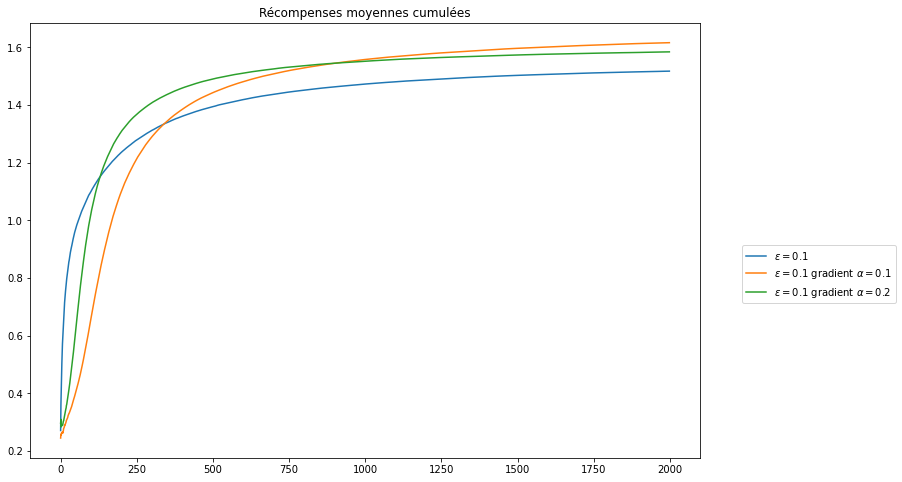

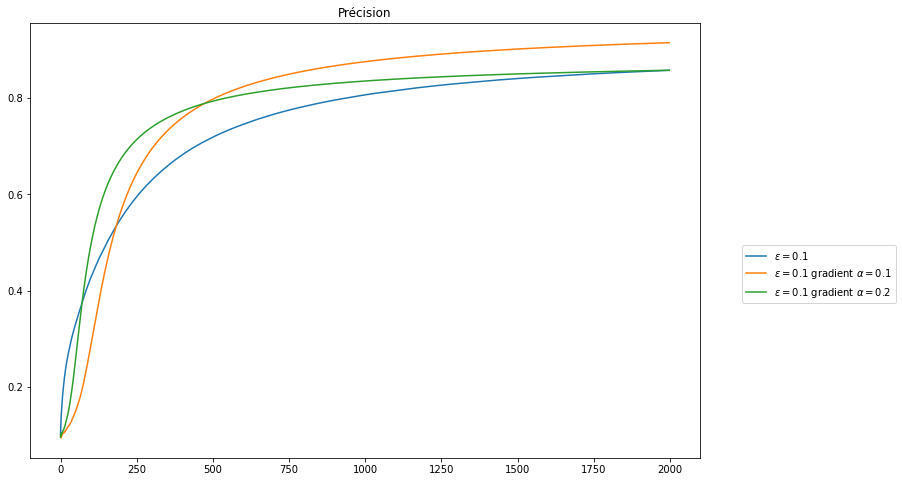

In [ ]:
plt.figure(figsize=(12,8))
plt.title("Récompenses moyennes cumulées")
plt.plot(eps_01_reward_average[1:], label="$\epsilon=0.1$")
plt.plot(eps_01_grad1_reward_average[1:], label=r"$\epsilon=0.1$ gradient $\alpha=0.1$")
plt.plot(eps_01_grad5_reward_average[1:], label=r"$\epsilon=0.1$ gradient $\alpha=0.2$")
plt.legend(bbox_to_anchor=(1.3, 0.5))

plt.figure(figsize=(12,8))
plt.title("Précision")
plt.plot(eps_01_accu_average[1:], label="$\epsilon=0.1$")
plt.plot(eps_01_grad1_accu_average[1:], label=r"$\epsilon=0.1$ gradient $\alpha=0.1$")
plt.plot(eps_01_grad5_accu_average[1:], label=r"$\epsilon=0.1$ gradient $\alpha=0.2$")
plt.legend(bbox_to_anchor=(1.3, 0.5))

On remarque que la méthode de montée de gradient permet d'atteindre de meilleurs résultats que la méthode ϵ-gradient (ϵ=0.1).
Le coeffcient α est le taux d'apprentissage, plus il est élevé et plus le terme de correction dans la mise à jour des préférences est important.
On aurait adopter une stratégie avec un taux d'apprentissage dégressif (adaptatif). 